# POP 1°: Redi term

TODO:

- [ ] compare $σ_θ$ and $σ_1$
- [x] compare first and last cycle

upstream

- [ ] coarsen and coords
- [ ] eos with zeros_like(z_t) or zeros_like(TEMP)
- [ ] set metrics on pop_tools grid; set more CF attributes
- [ ] xgcm transform expects 1D
- [ ] xgcm transform and broadcasting
- [ ] xgcm with target as pint quantity

In [1]:
%load_ext watermark

import glob

import cf_xarray as cfxr
import cf_xarray.units
import dask.array
import dcpy
# import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint_xarray
import pop_tools
import xarray as xr
import xgcm

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.style.use("bmh")

%watermark -iv

pop_tools  : 2021.5.28.post23+dirty
numpy      : 1.21.5
dcpy       : 0.1
json       : 2.0.9
dask       : 2022.3.0
xarray     : 2022.3.0
xgcm       : 0.6.1
cf_xarray  : 0.7.1.dev12+g5ed9838
sys        : 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0]
pint_xarray: 0.2.1
pandas     : 1.4.1
matplotlib : 3.5.1



In [2]:
import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(project="ncgd0011")
cluster.scale(4)
import distributed

client = distributed.Client(cluster)
client

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.35:37354,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
path = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1"
paths = []
for substring in [".TEMP.", "KAPPA_ISOP", ".SALT."]:
    paths += glob.glob(f"{path}/*{substring}*.nc")
paths

['/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.pop.h.TEMP.024501-030512.nc',
 '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.pop.h.TEMP.012301-018312.nc',
 '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.pop.h.TEMP.030601-036612.nc',
 '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001.pop.h.TEMP.000101-006112.nc',
 '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001/ocn/proc/tseries/month_1/g.e21.GOMIPECOIAF_JRA.TL319_g17.C

In [6]:
ds = xr.open_mfdataset(
    paths,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    chunks={"time": 200, "nlon": 50, "nlat": 50},
).drop_vars(["lat_aux_grid"])
ds["time"] = ds.time - xr.coding.cftime_offsets.MonthBegin(1)
ds["σ"] = pop_tools.eos(ds.SALT, ds.TEMP, depth=xr.full_like(ds.z_t, 2000)) - 1000
ds["σ"].attrs["long_name"] = "$σ_2$"
ds.σ.attrs["grid_loc"] = ds.TEMP.attrs["grid_loc"]
ds

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, moc_z: 61, nlat: 384, nlon: 320,
                             time: 4392, d2: 2)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time                    (time) object 0001-01-01 00:00:00 ... 0366-12-01 ...
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) object dask.array<chunksize=(200, 2), meta=np.ndarray>
    KAPPA_ISOP              (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    SALT                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
    σ                       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(200, 60, 50, 50), meta=np.ndarray>
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [5]:
dask.config.set({"array.chunk-size": "512MiB"})

In [7]:
reshaped = (
    ds.coarsen(time=12 * 61)
    .construct({"time": ("cycle", "yearmonth")})
    .set_coords(["ULONG", "ULAT", "TLONG", "TLAT"])
)

# assign nice coordinates
reshaped["cycle"] = np.arange(6)
year = (np.mod(reshaped.time.isel(cycle=0).dt.year.data-1, 61) + 1)
month = np.hstack([np.arange(1, 13)] * 61)
reshaped["yearmonth"] = ("yearmonth", pd.MultiIndex.from_arrays((year, month), names=("year", "month")), {"axis": "T"})

# select out years 42-61
reshaped = reshaped.sel(yearmonth=reshaped.year.isin(np.arange(42, 62)))
reshaped

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3369: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  exec(code_obj, self.user_global_ns, self.user_ns)
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...   

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, moc_z: 61, nlat: 384, nlon: 320,
                             cycle: 6, yearmonth: 240, d2: 2)
Coordinates: (12/13)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    time                    (cycle, yearmonth) object 0042-01-01 00:00:00 ......
  * cycle                   (cycle) int64 0 1 2 3 4 5
  * yearmonth               (yearmonth) MultiIndex
  - year                    (yearmonth) int64 42 42 42 42 42 ... 61 61 61 61 61
  - month                   (yearmonth) int64 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (cycle, yearmonth, d2) object dask.array<chunksize=(1, 240, 2), meta=np.ndarray>
    KAPPA_ISOP              (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 240, 60, 50, 50), meta=np.ndarray>
    SALT                    (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 240, 60, 50, 50), meta=np.ndarray>
    TEMP                    (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 240, 60, 50, 50), meta=np.ndarray>
    σ                       (cycle, yearmonth, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 240, 60, 50, 50), meta=np.ndarray>
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [8]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    # ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

region = reshaped.cf.isel(nlon=slice(7, 17), nlat=slice(265, 276))
grid, xds = pop_tools.to_xgcm_grid_dataset(
    region.pint.quantify(),
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)
xds.nlon_t.attrs["axis"] = "X"
xds.nlat_t.attrs["axis"] = "Y"
# xds["yearmonth"] = ("yearmonth", np.arange(xds.sizes["yearmonth"]), {"axis": "T"})
xds.update(xds.cf[["latitude", "longitude"]].load())
xds

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_w_top: 60, nlat_t: 11, nlon_t: 10,
                             nlat_u: 11, nlon_u: 10, cycle: 6, yearmonth: 240,
                             d2: 2, z_t_150m: 15, z_w_bot: 60, moc_z: 61)
Coordinates: (12/16)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat_u, nlon_u) float64 [degrees_east] 329.0 ......
    ...                      ...
  * cycle                   (cycle) int64 0 1 2 3 4 5
  * yearmonth               (yearmonth) MultiIndex
  - year                    (yearmonth) int64 42 42 42 42 42 ... 61 61 61 61 61
  - month                   (yearmonth) int64 1 2 3 4 5 6 7 ... 6 7 8 9 10 11 12
  * nlon_u                  (nlon_u) int64 1 2 3 4 5 6 7 8 9 10
  * nlat_u                  (nlat_u) int64 1 2 3 4 5 6 7 8 9 10 11
  * nlon_t                  (nlon_t) float64 0.5 1.5 2.5 3.5 ... 6.5 7.5 8.5 9.5
  * nlat_t                  (nlat_t) float64 0.5 1.5 2.5 3.5 ... 8.5 9.5 10.5
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 [] dask.array<open_dataset-c54fa...
    transport_components    (transport_comp) |S384 [] dask.array<open_dataset...
    transport_regions       (transport_reg) |S384 [] dask.array<open_dataset-...
    dz                      (z_t) float32 [cm] dask.array<open_dataset-c54fa2...
    dzw                     (z_w_top) float32 [cm] dask.array<open_dataset-c5...
    KMT                     (nlat_t, nlon_t) float64 dask.array<chunksize=(11, 10), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 8.297e+04
    time_bound              (cycle, yearmonth, d2) object dask.array<chunksize=(1, 240, 2), meta=np.ndarray>
    KAPPA_ISOP              (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [cm²/s] dask.array<getitem, shape=(6, 240, 60, 11, 10), dtype=float32, chunksize=(1, 240, 60, 11, 10), chunktype=numpy.n...
    SALT                    (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [g/kg] dask.array<getitem, shape=(6, 240, 60, 11, 10), dtype=float32, chunksize=(1, 240, 60, 11, 10), chunktype=numpy.nd...
    TEMP                    (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [°C] dask.array<getitem, shape=(6, 240, 60, 11, 10), dtype=float32, chunksize=(1, 240, 60, 11, 10), chunktype=numpy.ndar...
    σ                       (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [kg/m³] dask.array<getitem, shape=(6, 240, 60, 11, 10), dtype=float32, chunksize=(1, 240, 60, 11, 10), chunktype=numpy.n...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

## Choosing density bins

### Mean fields in NATRE region

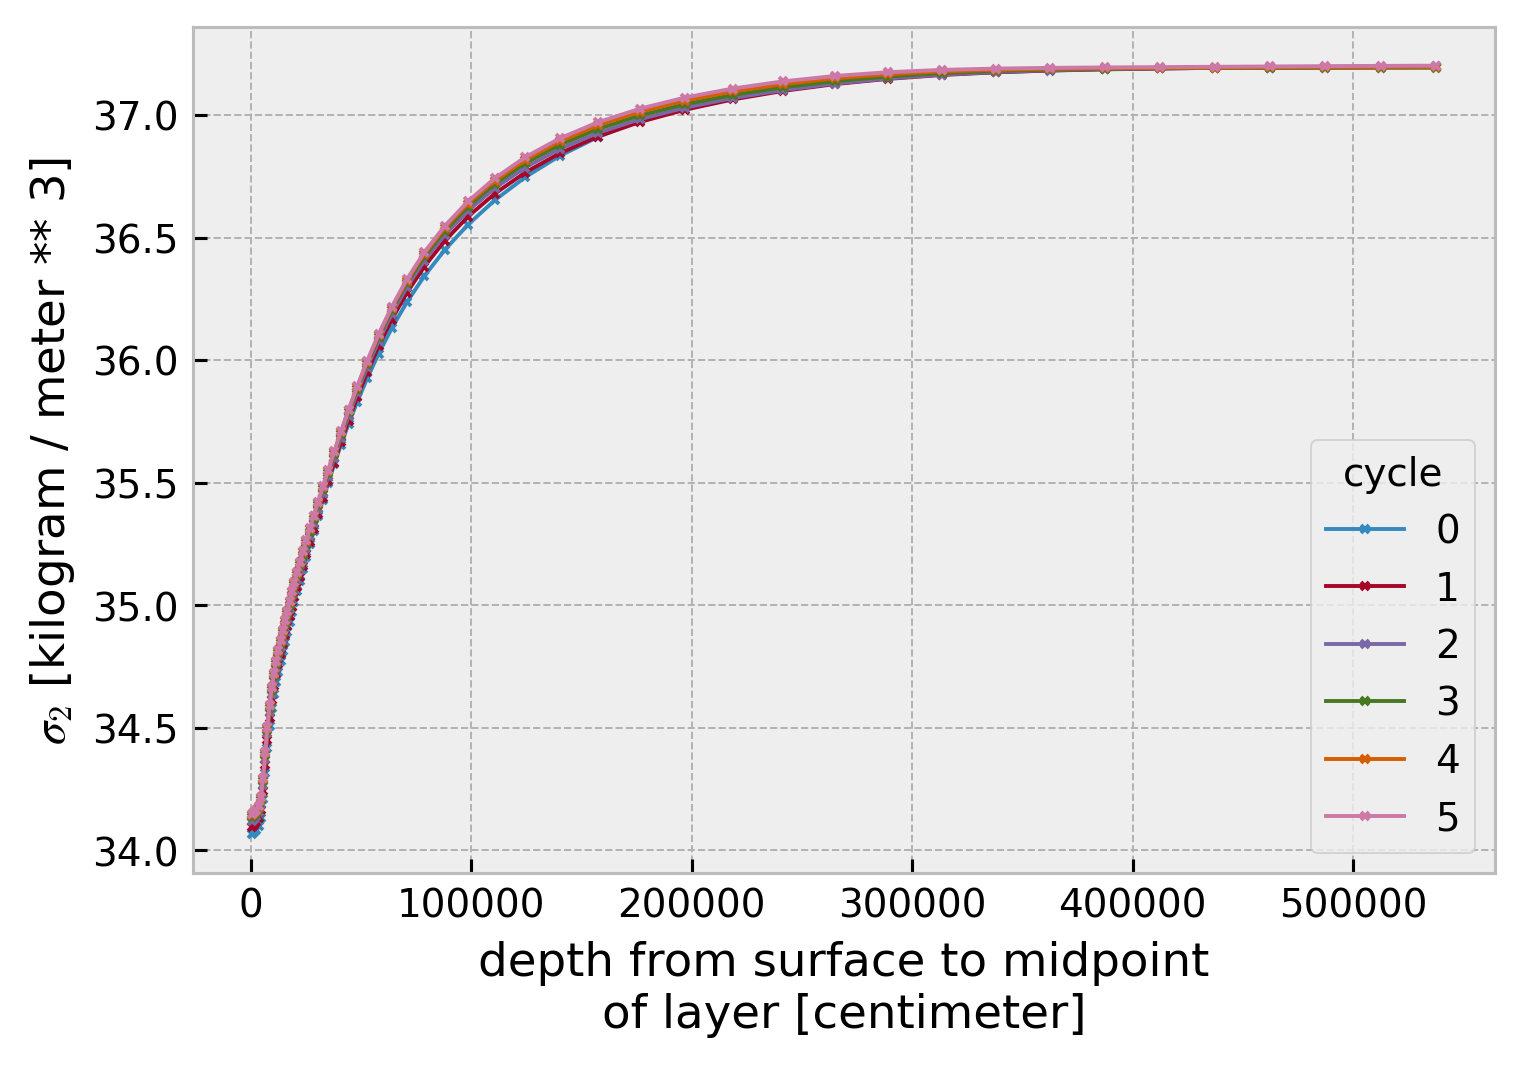

In [15]:
meanrho = xds.σ.cf.mean(["T", "Y", "X"]).load()
meanrho.plot(hue="cycle", marker='x', lw=1, ms=2)

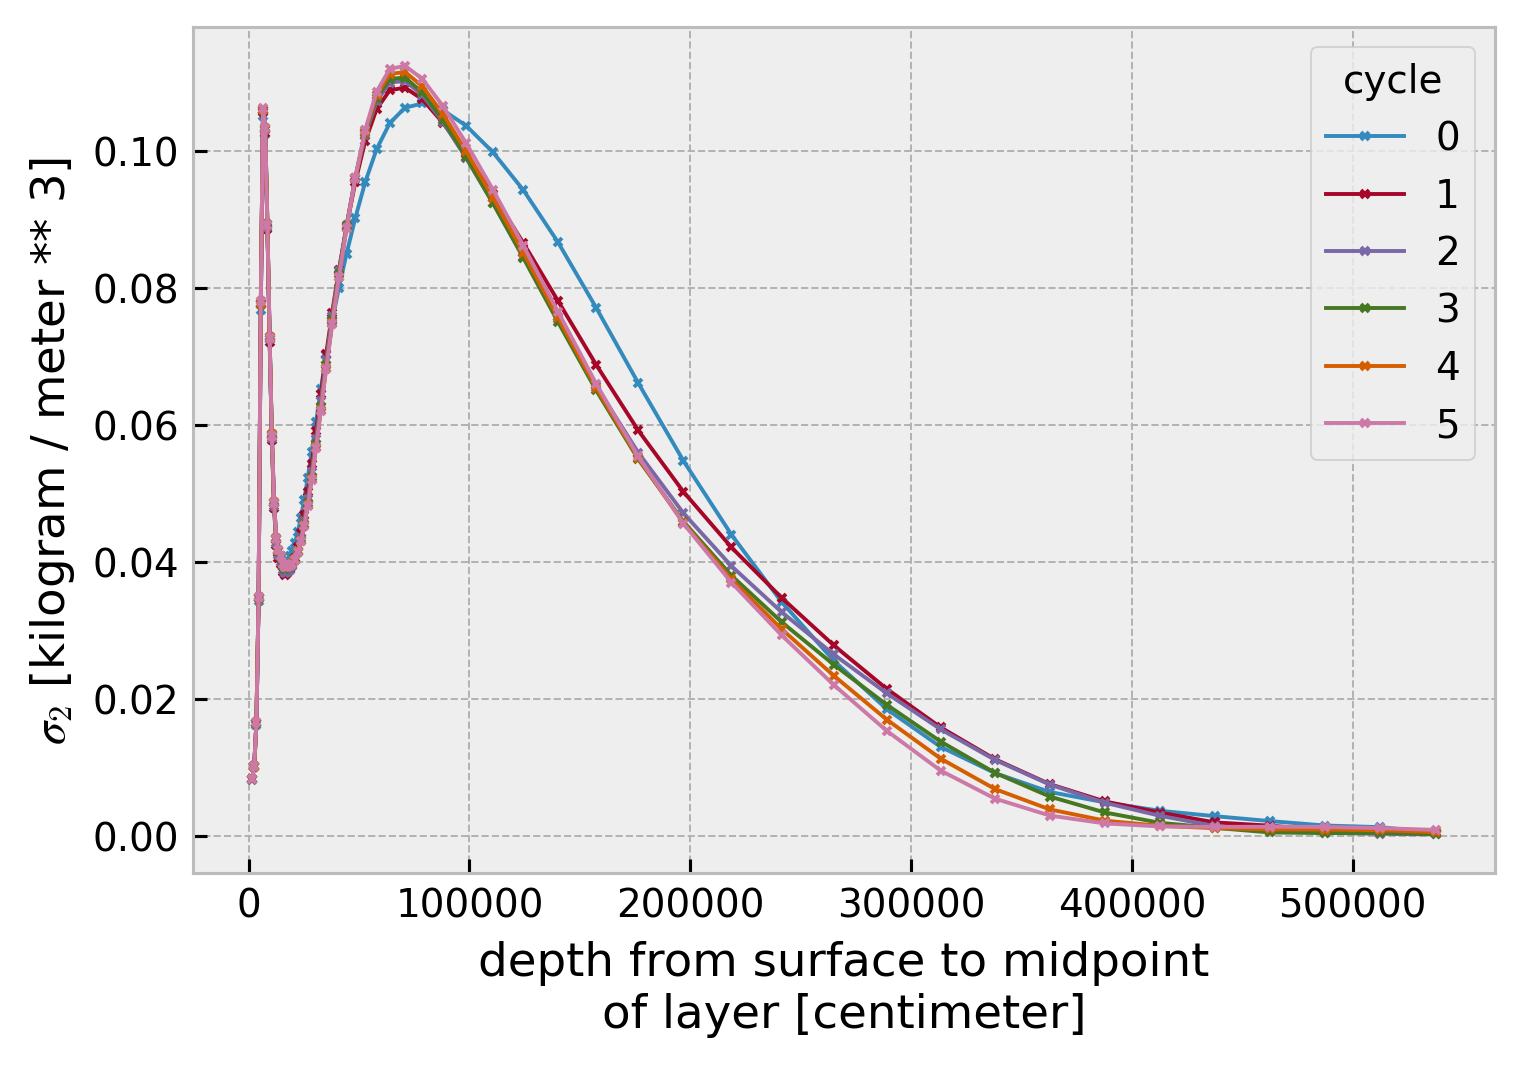

In [16]:
meanrho.cf.diff("Z").plot(marker='x', ms=2, lw=1, hue="cycle")

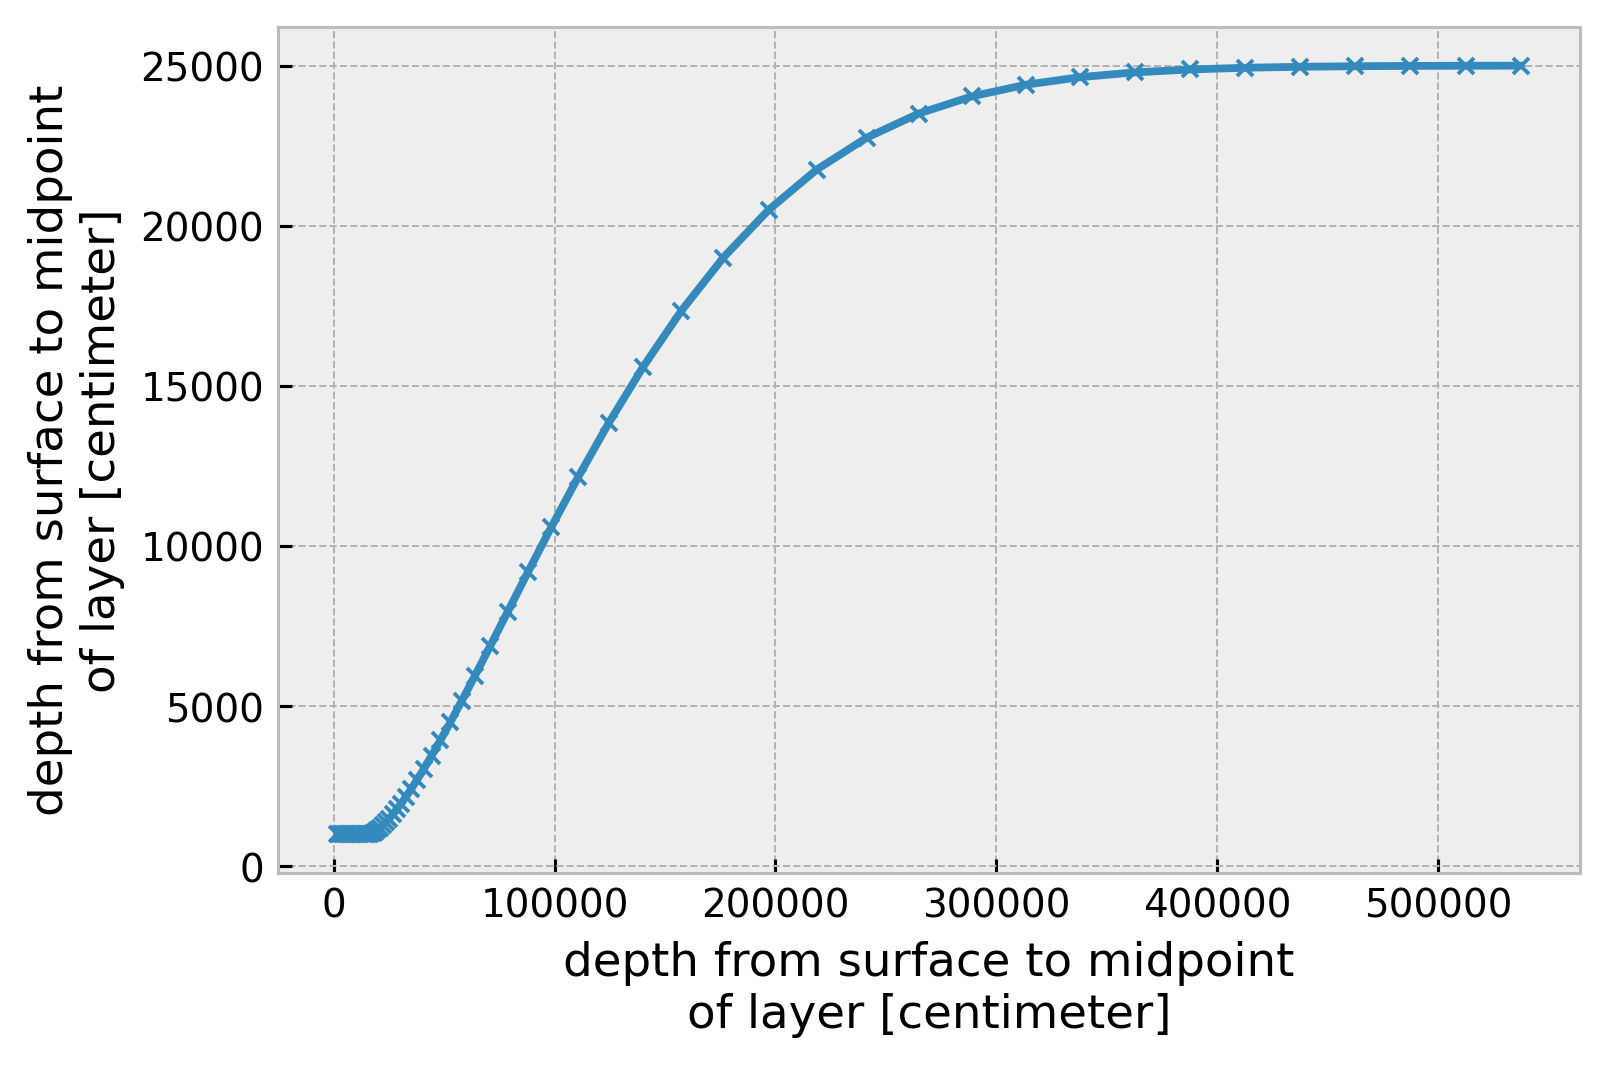

In [17]:
xds.z_t.diff("z_t").plot(ms=4, marker='x')

## Regrid to isopycnal space

In [35]:
regridded

<xarray.Dataset>
Dimensions:     (cycle: 6, yearmonth: 240, z_t: 60, nlat_t: 11, nlon_t: 10)
Coordinates:
    σ           (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [kg/m³] dask....
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] 328.4 329.5 ... 338.4
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] 23.5 23.51 ... 28.2
    time        (cycle, yearmonth) object 0042-01-01 00:00:00 ... 0366-12-01 ...
  * cycle       (cycle) int64 0 1 2 3 4 5
  * yearmonth   (yearmonth) MultiIndex
  - year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  - month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5
Data variables:
    z           (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 240, 60, 11, 10), meta=np.ndarray>
    TEMP        (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [°C] dask.arr...
    KAPPA_ISOP  (cycle, yearmonth, z_t, nlat_t, nlon_t) float32 [cm²/s] dask....
    delT2       (cycle, yearmonth, z_t, nlat_t, nlon_t) float64 [Δ°C²/cm²] da...
    RediVar     (cycle, yearmonth, z_t, nlat_t, nlon_t) float64 [Δ°C²/s] dask...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [82]:
from functools import partial


def gridder(da, target):
    da = da.pint.dequantify()
    interped = xr.concat(
        [
            grid.transform(
                da.sel(cycle=cycle),
                axis="Z",
                target=target,
                target_data=da.σ.sel(cycle=cycle),
                method="linear",
            )
            for cycle in da.cycle
        ],
        dim="cycle",
        join="exact",
    )
    interped.attrs = da.attrs
    return interped

bins = np.sort(meanrho.isel(cycle=-1).pint.dequantify().data)
newz = xds.TEMP.copy(
    data=dask.array.broadcast_to(
        xds.z_t.data[np.newaxis, :, np.newaxis, np.newaxis],
        xds.TEMP.shape,
        chunks=xds.TEMP.chunks,
    ),
)
newz.name = "z"
newz.attrs = {}
xds["z"] = newz
regridded = (
    xds.set_coords("σ")[["z", "TEMP", "KAPPA_ISOP"]]
    .map(gridder, target=bins)
    .rename_vars({"z": "z_t"})
)

regridded["yearmonth"] = xds.yearmonth

for var in regridded.variables:
    if var in xds:
        regridded[var].attrs = xds[var].attrs
        try:
            regridded[var].attrs["units"] = str(xds[var].data.units)
        except AttributeError:
            pass
regridded.z_t.attrs = {"axis": "Z", "positive": "down", "units": "centimeters"}
regridded = regridded.pint.quantify()

dTdy = grid.derivative(regridded.TEMP, axis="Y")
dTdx = grid.derivative(regridded.TEMP, axis="X")
regridded["delT2"] = grid.interp(dTdx, axis="X") ** 2 + grid.interp(dTdy, axis="Y") ** 2
regridded["RediVar"] = regridded.KAPPA_ISOP * regridded.delT2

regridded["KAPPA_ISOP"].attrs = {"long_name": "$K_{redi}$"}
regridded["delT2"].attrs = {"long_name": "$|∇T|^2$"}
regridded["RediVar"].attrs = {"long_name": "$K_{redi} |∇T|^2$"}
regridded.time.attrs.clear()
regridded

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning: Metric at ('cycle', 'yearmonth', 'nlat_u', 'nlon_t', 'σ') being interpolated from metrics at dimensions ('nlat_t', 'nlon_t'). Boundary value set to 'extend'.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xgcm/grid.py:1515: UserWarning: Metric at ('cycle', 'yearmonth', 'nlat_t', 'nlon_u', 'σ') being interpolated from metrics at dimensions ('nlat_t', 'nlon_t'). Boundary value set to 'extend'.
  warnings.warn(


<xarray.Dataset>
Dimensions:     (cycle: 6, yearmonth: 240, nlat_t: 11, nlon_t: 10, σ: 60)
Coordinates:
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] 328.4 329.5 ... 338.4
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] 23.5 23.51 ... 28.2
    time        (cycle, yearmonth) object 0042-01-01 00:00:00 ... 0366-12-01 ...
  * cycle       (cycle) int64 0 1 2 3 4 5
  * yearmonth   (yearmonth) MultiIndex
  - year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  - month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5
  * σ           (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
Data variables:
    z_t         (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [cm] dask.array...
    TEMP        (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [°C] dask.array...
    KAPPA_ISOP  (cycle, yearmonth, nlat_t, nlon_t, σ) float32 [cm²/s] dask.ar...
    delT2       (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/cm²] dask...
    RediVar     (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/s] dask.a...
Attributes:
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [83]:
(
    regridded
    .reset_index("yearmonth")
    .pint.dequantify()
    .load()
    #.pipe(cfxr.encode_multi_index_as_compress)
    .to_zarr("../datasets/pop-1deg-redi-var-natre-0042-0061.zarr", mode="w")
)

## Compute Redi variance production

In [91]:
regridded = (
    xr.load_dataset("../datasets/pop-1deg-redi-var-natre-0042-0061.zarr", engine="zarr")
    #.pipe(cfxr.decode_compress_to_multi_index)
    #.cf.guess_coord_axis()
    .pint.quantify()
)
regridded

<xarray.Dataset>
Dimensions:     (cycle: 6, yearmonth: 240, nlat_t: 11, nlon_t: 10, σ: 60)
Coordinates:
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] 23.5 23.51 ... 28.2
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] 328.4 329.5 ... 338.4
  * cycle       (cycle) int64 0 1 2 3 4 5
    month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
    time        (cycle, yearmonth) object 0042-01-01 00:00:00 ... 0366-12-01 ...
    year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  * σ           (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
Dimensions without coordinates: yearmonth
Data variables:
    KAPPA_ISOP  (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [cm²/s] nan ......
    RediVar     (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/s] nan .....
    TEMP        (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [°C] nan ... nan
    delT2       (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/cm²] nan ...
    z_t         (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [cm] nan ... nan
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    time_period_freq:  month_1
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001

## NATRE region

In [94]:
natre = regridded #.cf.isel(X=slice(7, 17), Y=slice(265, 276))
natre

<xarray.Dataset>
Dimensions:     (cycle: 6, yearmonth: 240, nlat_t: 11, nlon_t: 10, σ: 60)
Coordinates:
    TLAT        (nlat_t, nlon_t) float64 [degrees_north] 23.5 23.51 ... 28.2
    TLONG       (nlat_t, nlon_t) float64 [degrees_east] 328.4 329.5 ... 338.4
  * cycle       (cycle) int64 0 1 2 3 4 5
    month       (yearmonth) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
  * nlat_t      (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5
  * nlon_t      (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5
    time        (cycle, yearmonth) object 0042-01-01 00:00:00 ... 0366-12-01 ...
    year        (yearmonth) int64 42 42 42 42 42 42 42 ... 61 61 61 61 61 61 61
  * σ           (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
Dimensions without coordinates: yearmonth
Data variables:
    KAPPA_ISOP  (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [cm²/s] nan ......
    RediVar     (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/s] nan .....
    TEMP        (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [°C] nan ... nan
    delT2       (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [Δ°C²/cm²] nan ...
    z_t         (cycle, yearmonth, nlat_t, nlon_t, σ) float64 [cm] nan ... nan
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    time_period_freq:  month_1
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001

There is spiciness

/glade/u/home/dcherian/miniconda3/envs/eddydiff/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:635: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return push(array, n, axis)


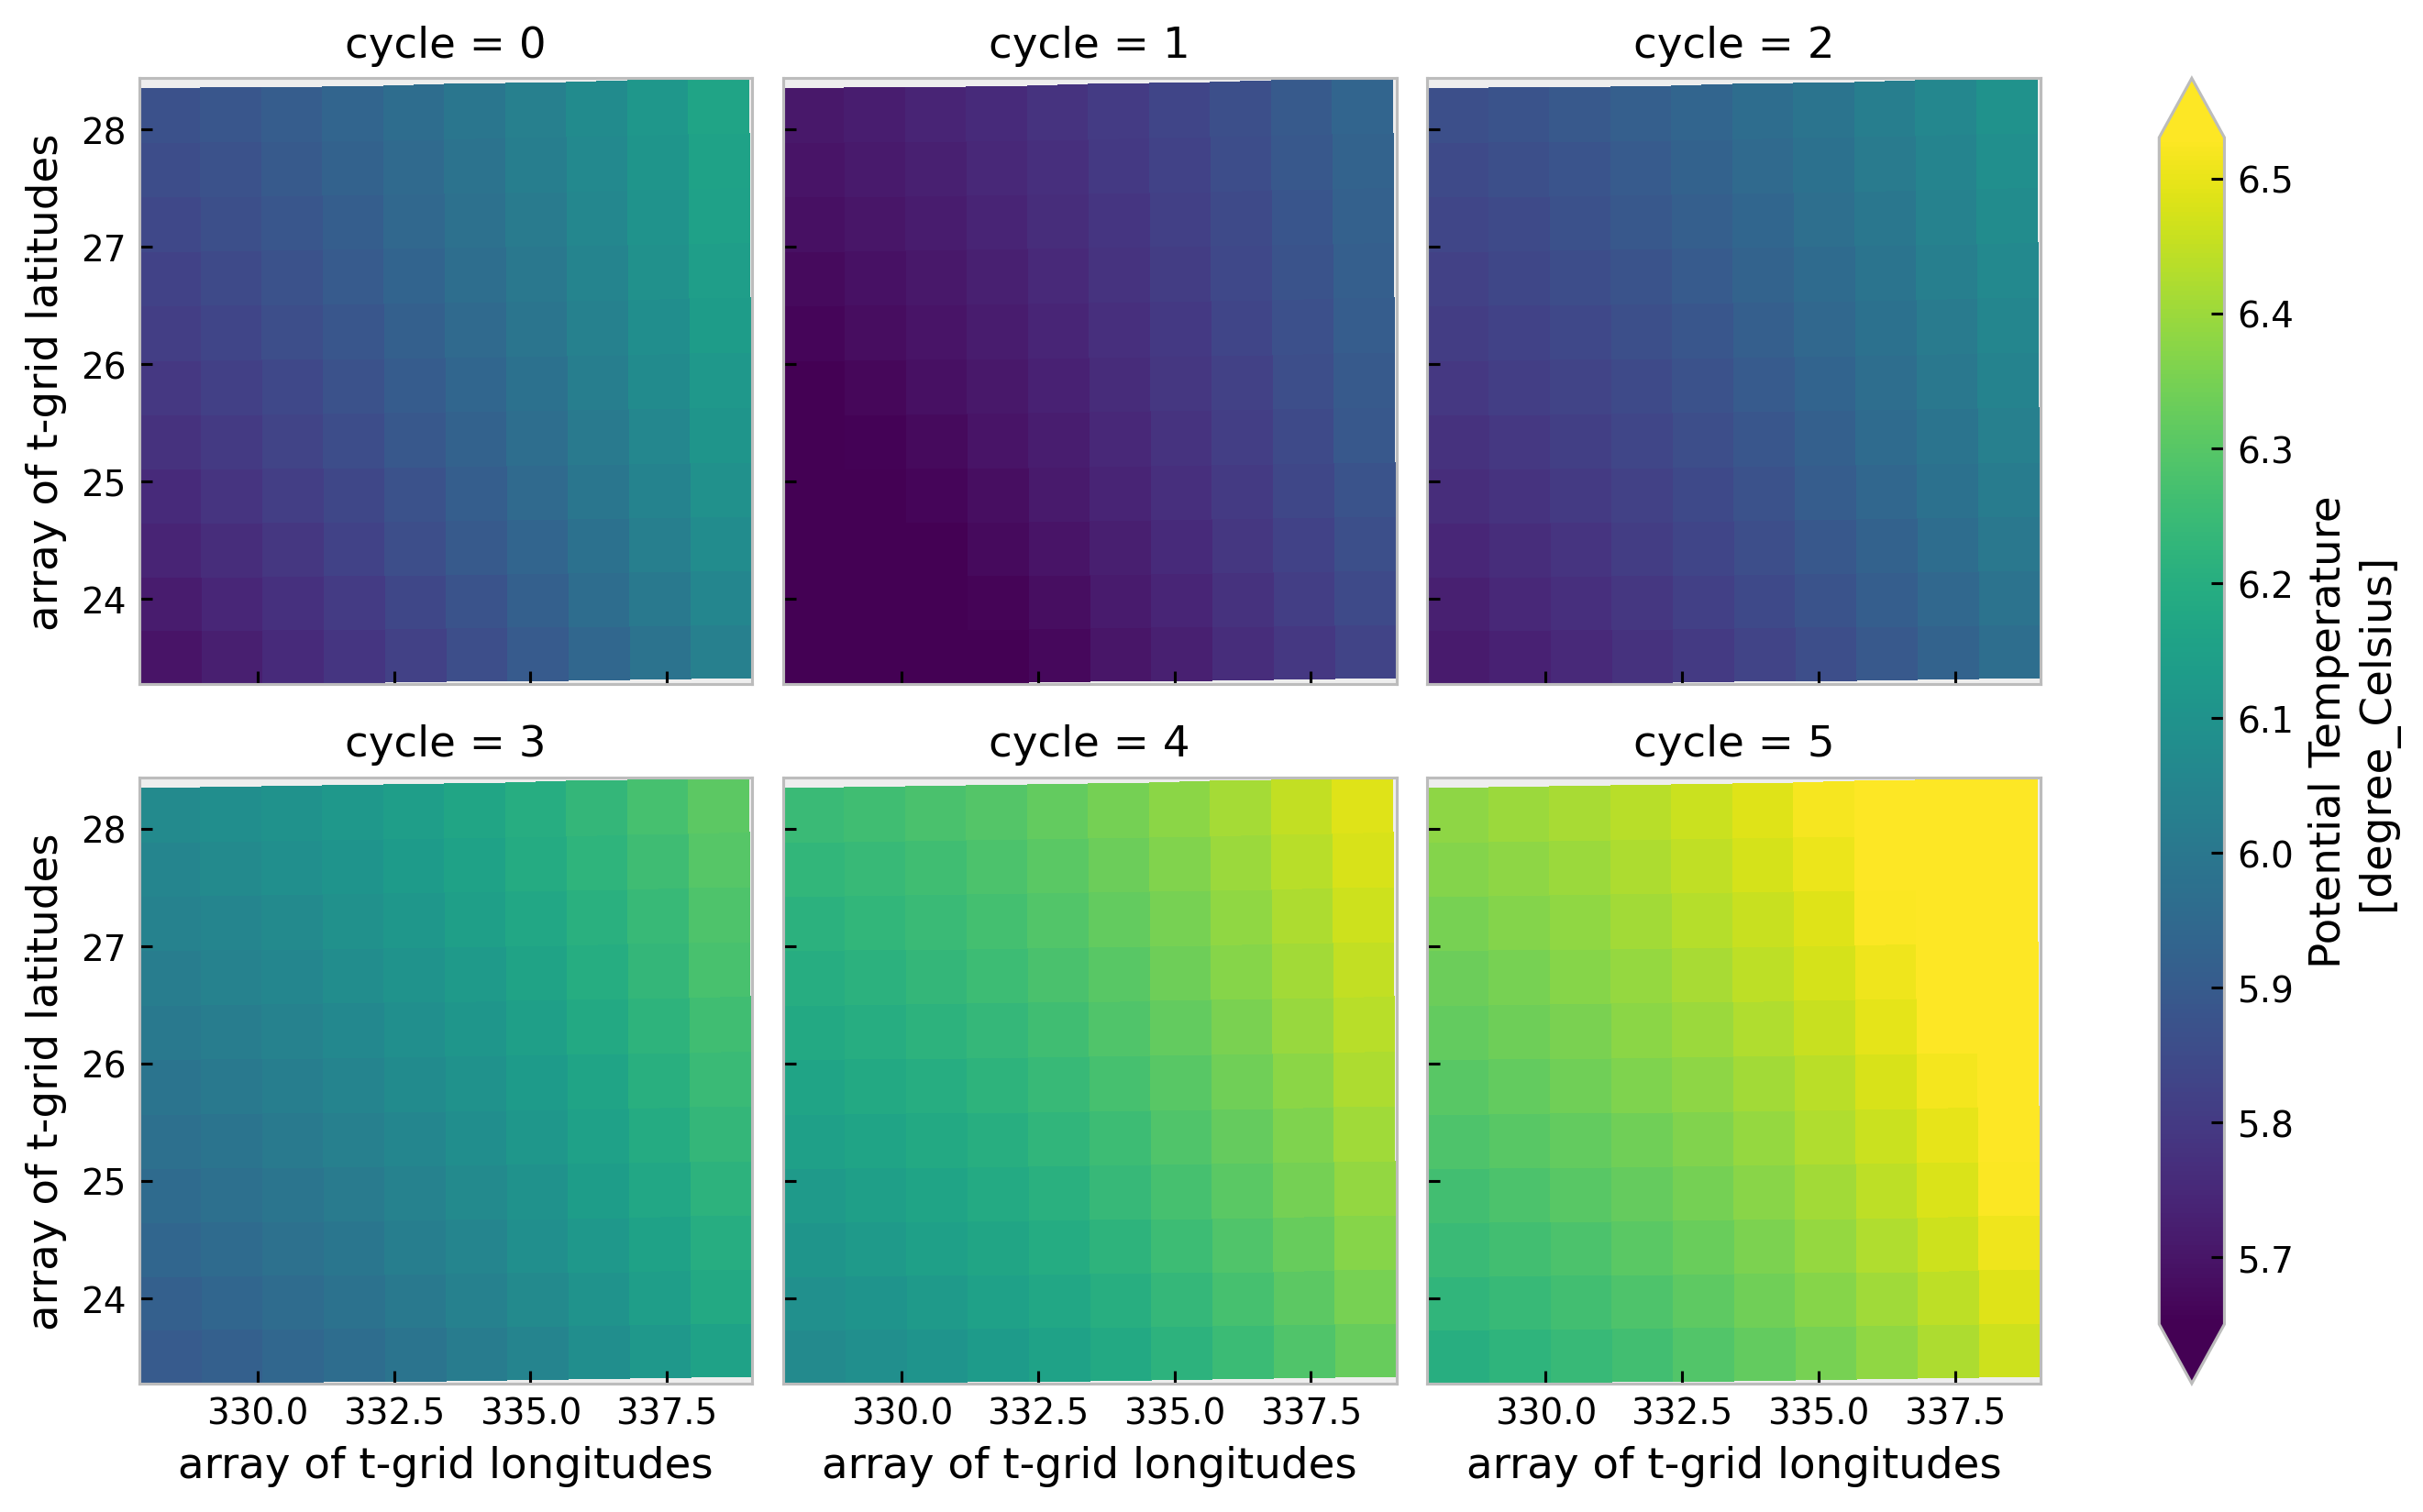

In [87]:
import matplotlib.pyplot as plt

subset = natre.mean("yearmonth").isel(σ=40)
subset["TLAT"] = subset.TLAT.cf.ffill("X")
subset["TLONG"] = subset.TLONG.cf.bfill("Y")
subset.TEMP.plot(x="TLONG", y="TLAT", col="cycle", col_wrap=3, robust=True)

In [88]:
profile = (
    natre.reset_coords("z_t")
    .cf.mean(["yearmonth", "Y", "X"])
    .load()
    # convert to SI units
    .map(lambda da: da.copy(data=da.data.to_base_units()))
    .set_coords("z_t")
)
profile

<xarray.Dataset>
Dimensions:     (cycle: 6, σ: 60)
Coordinates:
  * cycle       (cycle) int64 0 1 2 3 4 5
  * σ           (σ) float32 34.15 34.16 34.17 34.18 ... 37.2 37.2 37.2 37.2
    z_t         (cycle, σ) float64 [m] 66.9 67.23 67.65 ... 5.036e+03 5.166e+03
Data variables:
    KAPPA_ISOP  (cycle, σ) float64 [m²/s] 2.488e+03 2.486e+03 ... 508.3 464.9
    RediVar     (cycle, σ) float64 [K²/s] 2.956e-09 2.951e-09 ... 8.636e-13
    TEMP        (cycle, σ) float64 [K] 295.8 295.8 295.7 ... 274.8 274.8 274.8
    delT2       (cycle, σ) float64 [K²/m²] 1.157e-12 1.156e-12 ... 1.605e-15
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    history:           none
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    start_time:        This dataset was created on 2019-06-20 at 13:53:17.7
    time_period_freq:  month_1
    title:             g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001

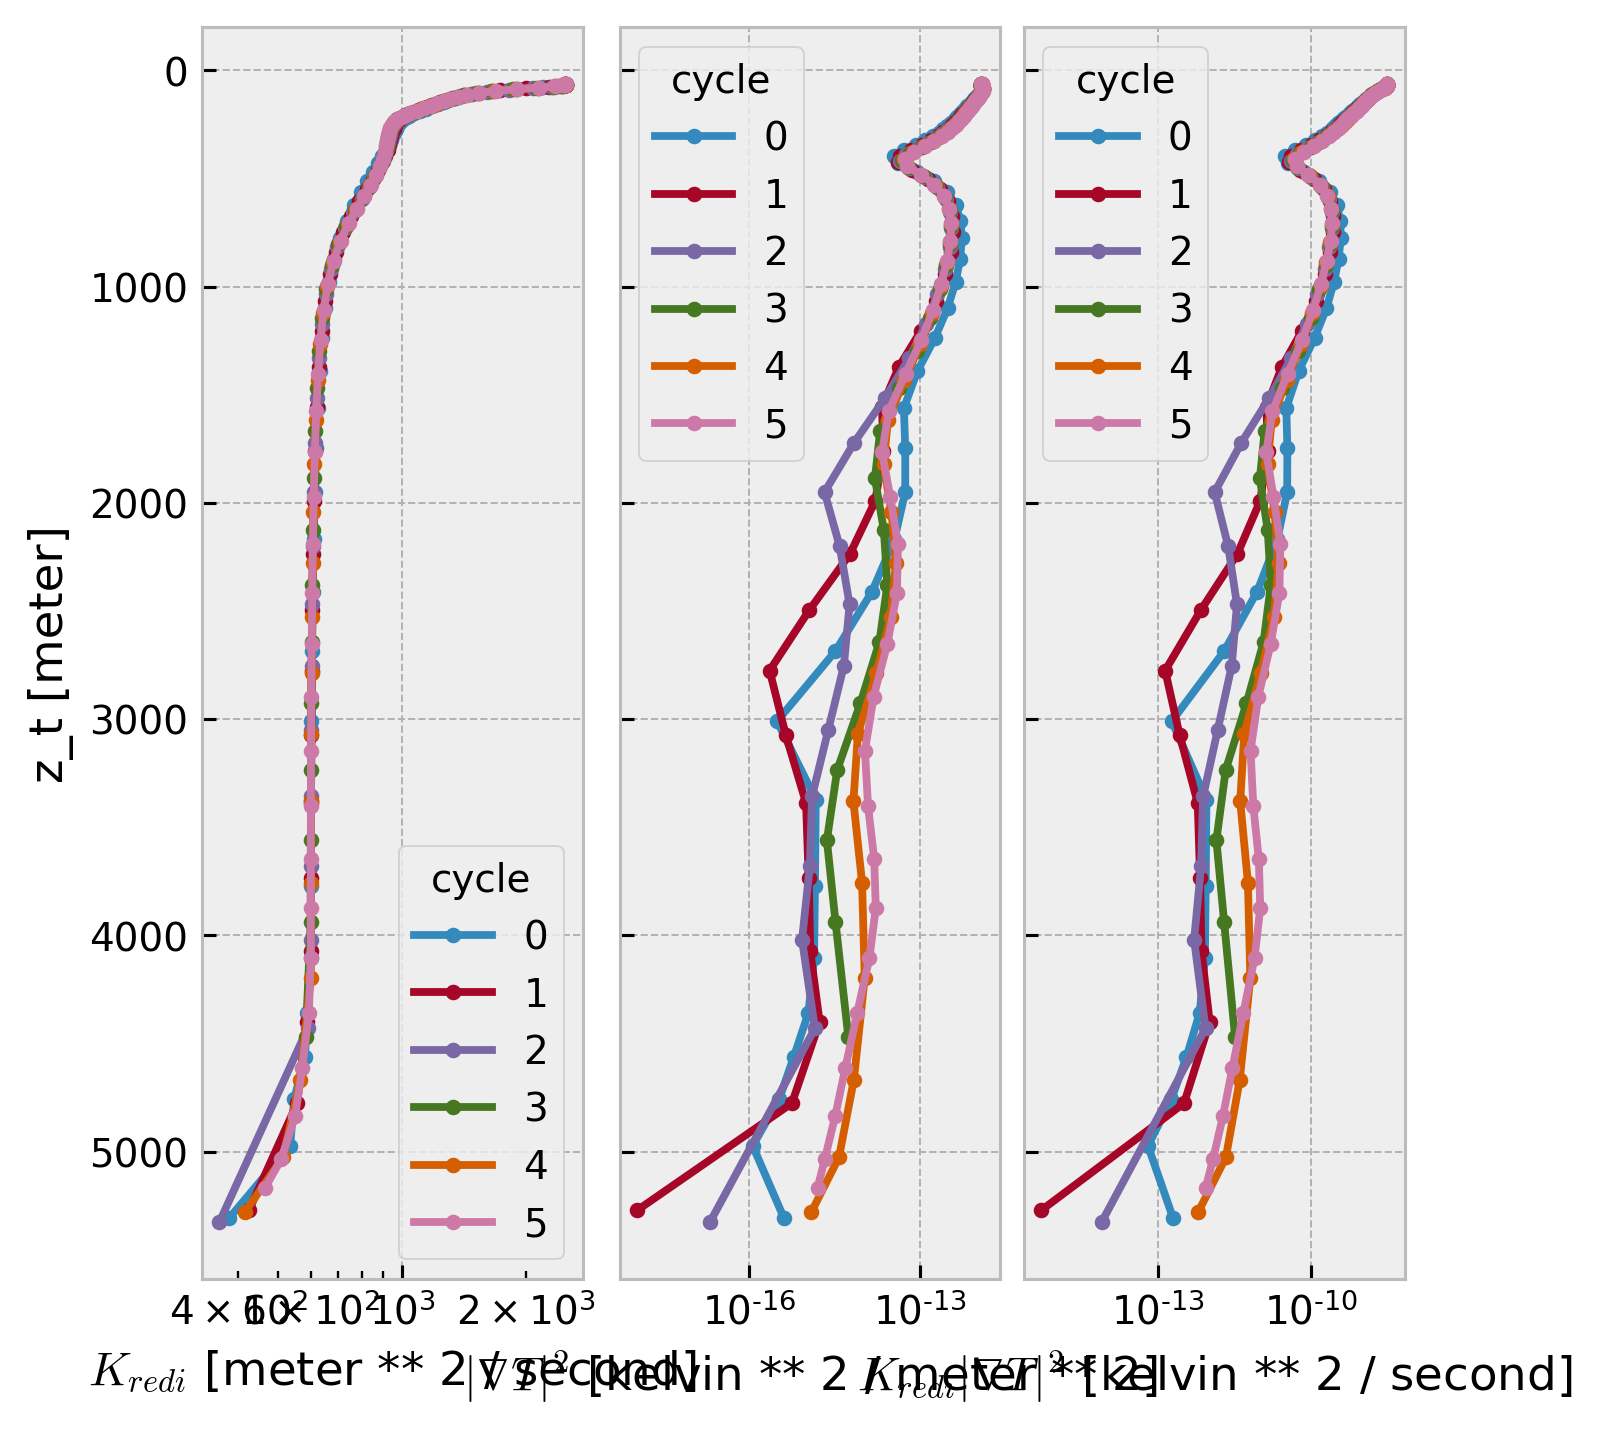

In [89]:
import dcpy
plt.style.use("bmh")
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
profile.KAPPA_ISOP.cf.plot(ax=ax[0], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log")
profile.delT2.cf.plot(
    ax=ax[1], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log"
)
profile.RediVar.cf.plot(
    ax=ax[2], y="Z", marker=".", hue="cycle", yincrease=False, xscale="log"
)
dcpy.plots.clean_axes(ax)
f.set_size_inches((5,5))

In [95]:
profile.pint.dequantify().to_netcdf("../datasets/pop-1deg-redivar-natre.nc")

## Climatology

In [8]:
climdir = "/glade/scratch/bryan/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/tavg"
%ls /glade/scratch/bryan/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/tavg

g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-01.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-02.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-03.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-04.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-05.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-06.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-07.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-08.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-09.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-10.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-11.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061-12.nc
g.e20.G.TL319_t13.control.001_hfreq.pop.h.0042_0061.nc
